# Pipeline 
- Insertar Imagen
- Procesar Imagen
- Separar en líneas
- Enviar a los distintos OCRs
- Correcciones 
- Decisión Final

## Insertar Imágenes

In [1]:
import os


input_folder = "data/input"
os.makedirs(input_folder, exist_ok=True)
output_folder = "data/output_preprocessing"
os.makedirs(output_folder, exist_ok=True)

# Procesar Imágenes

In [2]:
# from Preprocessing.pipeline2 import cleanup_image

# cleanup_image(input_folder, output_folder)

## Separar en líneas

## Enviar a los distintos OCRs

In [3]:
import os
from typing import List
from Recognition.Kraken.kraken_model import get_transcription

processed_photos = sorted(os.listdir(output_folder))

transcriptions = []     # List of images [ List of models on the image [Dictionary { model: x , text: y } ] ]

for photo in processed_photos:
    transcriptions.append(get_transcription(output_folder + '/' + photo))


ocr_results = []    # List[List[List[str]]]

# Para cada imagen tenemos una transcripcion
for image in transcriptions:
    texts_list = []
    for dict in image:         # La transcripcion viene del modo model: x text: y
        lines = []
        text = dict['text']
        lines = text.split('\n')        # Separamos el texto por lineas
        texts_list.append(lines)
    ocr_results.append(texts_list)






Ejecutando OCR con el modelo bdd-wormser-scriptorium-abbreviated-0.2 sobre la imagen data/output_preprocessing/CODEA-0017_1r.png
Ejecutando OCR con el modelo McCATMuS_nfd_nofix_V1 sobre la imagen data/output_preprocessing/CODEA-0017_1r.png
OCR completado para todas las imágenes segmentadas.
Ejecutando OCR con el modelo bdd-wormser-scriptorium-abbreviated-0.2 sobre la imagen data/output_preprocessing/CODEA-0019_1r.png
Ejecutando OCR con el modelo McCATMuS_nfd_nofix_V1 sobre la imagen data/output_preprocessing/CODEA-0019_1r.png
OCR completado para todas las imágenes segmentadas.
Ejecutando OCR con el modelo bdd-wormser-scriptorium-abbreviated-0.2 sobre la imagen data/output_preprocessing/CODEA-0020_1r.png
Ejecutando OCR con el modelo McCATMuS_nfd_nofix_V1 sobre la imagen data/output_preprocessing/CODEA-0020_1r.png
OCR completado para todas las imágenes segmentadas.
Ejecutando OCR con el modelo bdd-wormser-scriptorium-abbreviated-0.2 sobre la imagen data/output_preprocessing/CODEA-0143

## Metrics

In [9]:
from testing.metrics import get_reference_text, compute_cer, compute_wer

cer_results = {}    # Character Error Rate
wer_results = {}    # Word Error Rate
    
for i, transcription in enumerate(transcriptions):
    reference_text = get_reference_text(processed_photos[i])

    cer_results[processed_photos[i]] = {}
    wer_results[processed_photos[i]] = {}

    if reference_text:
        for models_output in transcription:

            cer = compute_cer(reference_text, models_output['text'])
            wer = compute_wer(reference_text, models_output['text'])

            cer_results[processed_photos[i]][models_output['model']] = cer
            wer_results[processed_photos[i]][models_output['model']] = wer


KeyError: 'local_image_path'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


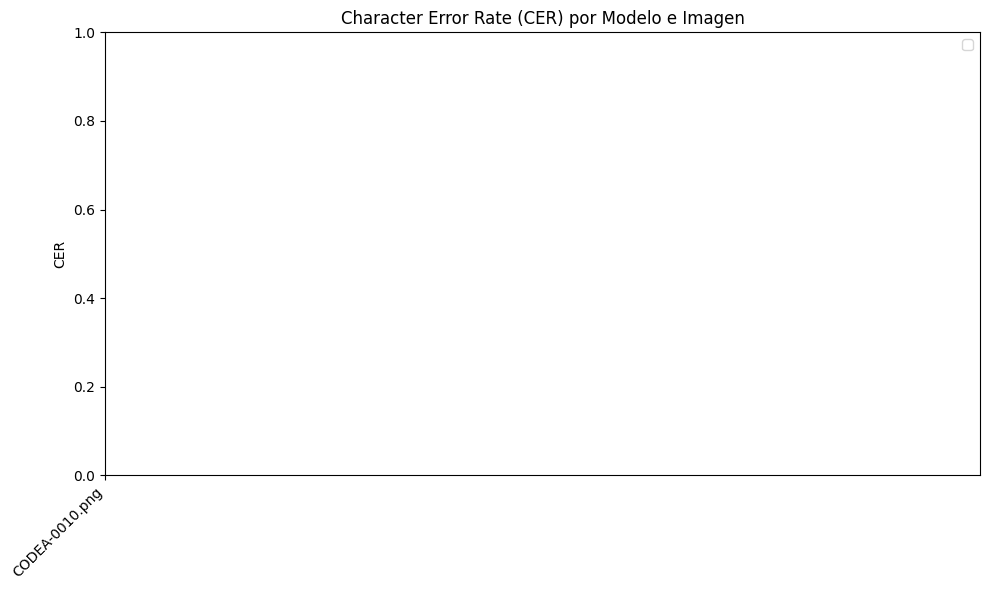

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


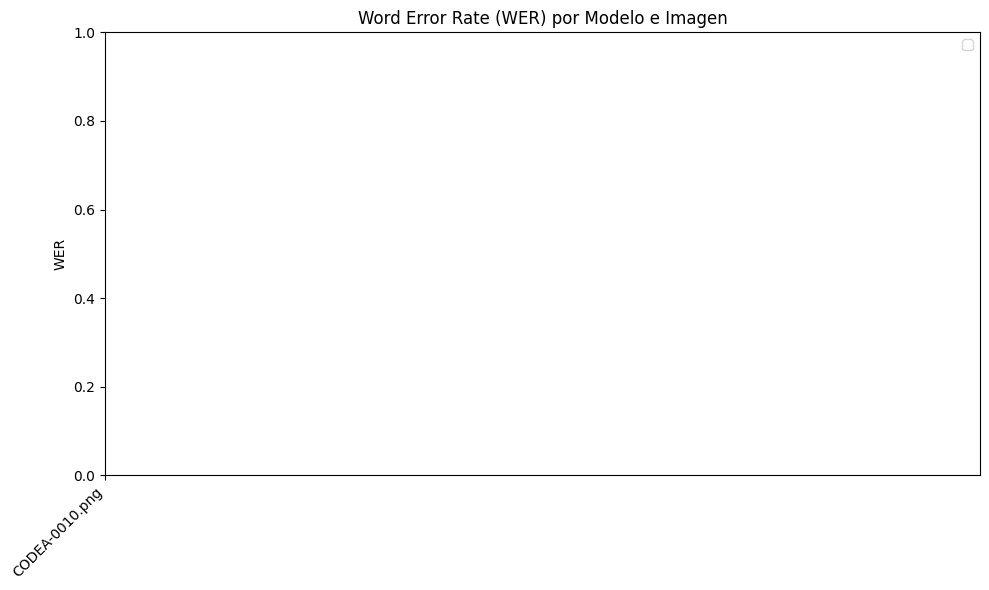

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cer_results(cer_results):
    """
    Genera una gráfica de barras agrupadas mostrando el CER
    (Character Error Rate) por imagen, dividido por cada modelo.
    """
    # Listamos todas las imágenes
    images = list(cer_results.keys())

    # Hallamos todos los modelos usados (unión de los modelos de cada imagen)
    all_models = set()
    for image in images:
        all_models.update(cer_results[image].keys())
    all_models = list(all_models)

    # Posiciones en el eje X
    x = np.arange(len(images))

    # Ancho de cada barra (ajusta según tu preferencia)
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))
    # Para cada modelo, pintamos una serie de barras
    for i, model in enumerate(all_models):
        cer_values = [cer_results[image].get(model, 0) for image in images]
        # Desplazamos las barras para que no se sobrepongan
        offset = (i - (len(all_models) - 1) / 2) * bar_width
        ax.bar(x + offset, cer_values, bar_width, label=model)

    ax.set_xticks(x)
    ax.set_xticklabels(images, rotation=45, ha='right')
    ax.set_ylabel('CER')
    ax.set_title('Character Error Rate (CER) por Modelo e Imagen')
    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_wer_results(wer_results):
    """
    Genera una gráfica de barras agrupadas mostrando el WER
    (Word Error Rate) por imagen, dividido por cada modelo.
    """
    # Listamos todas las imágenes
    images = list(wer_results.keys())

    # Hallamos todos los modelos usados
    all_models = set()
    for image in images:
        all_models.update(wer_results[image].keys())
    all_models = list(all_models)

    # Posiciones en el eje X
    x = np.arange(len(images))

    # Ancho de cada barra (ajusta según tu preferencia)
    bar_width = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))
    # Para cada modelo, pintamos una serie de barras
    for i, model in enumerate(all_models):
        wer_values = [wer_results[image].get(model, 0) for image in images]
        offset = (i - (len(all_models) - 1) / 2) * bar_width
        ax.bar(x + offset, wer_values, bar_width, label=model)

    ax.set_xticks(x)
    ax.set_xticklabels(images, rotation=45, ha='right')
    ax.set_ylabel('WER')
    ax.set_title('Word Error Rate (WER) por Modelo e Imagen')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_cer_results(cer_results)
plot_wer_results(wer_results)


## Correcciones

In [10]:
from serialization.serialization import correction, combine, load_corrector_model
import google.generativeai as genai
from dotenv import load_dotenv

# Cargar claves de entorno para Gemini
load_dotenv()
GENAI_API_KEY = os.getenv("GENAI_API_KEY")
genai.configure(api_key=GENAI_API_KEY)

spacy_model = "es_core_news_sm"
frequency_dictionary_path = "serialization/spanish_frequency_dictionary.txt"

# Cargar modelo SymSpell y Spacy
nlp, sym_spell = load_corrector_model(
    spacy_model=spacy_model,
    frequency_dictionary_path=frequency_dictionary_path,
    max_edit_distance=3,
    prefix_length=7
)

gemini_model_name="gemini-2.0-flash-exp"

# Crear el sistema de instrucciones para Gemini
chat = genai.GenerativeModel(
    model_name=gemini_model_name,
    system_instruction=[
        """
        Eres un asistente que ayuda a refinar textos. Analiza el siguiente texto original y corregido,
        y reescríbelo en un formato limpio, coherente y gramaticalmente correcto. Los textos son documentos históricos
        extraídos mediante OCR, por lo que pueden contener errores típicos del procesamiento OCR. Los documentos son
        actas capitulares de La Habana, Cuba, de los siglos XVI y XVII, manten el español antiguo ya que es un texto procesal cortesano.
        """
    ]
).start_chat(history=[])


In [11]:
results_from_corrections: List[List[str]] = []

for transcription in transcriptions:
    aux : List[str] = []
    for model in transcription:
        aux.append(correction(model['text'], nlp, sym_spell, chat))
    results_from_corrections.append(aux)


## Decisión Final

In [12]:
result:List[str] = []

# Crear el modelo generativo y configurar el sistema de instrucciones
chat2 = genai.GenerativeModel(
    model_name=gemini_model_name,
    system_instruction="""
        Eres un asistente que ayuda a refinar textos. Analiza el siguiente texto original y corregido,
        y reescríbelo en un formato limpio, coherente y gramaticalmente correcto. Los textos son documentos históricos
        extraídos mediante OCR, por lo que pueden contener errores típicos del procesamiento OCR. Los documentos son
        actas capitulares de La Habana, Cuba, de los siglos XVI y XVII, manten el español antiguo ya que es un texto procesal cortesano.
    """
).start_chat(history=[])

for it in range(len(ocr_results[0])):
    aux: List[str] = []
    for i in range(len(ocr_results)):
        aux.append(results_from_corrections[i][it])
    
    result.append(combine(aux, chat2))

print("RESULT FINAL")
print(result)

RESULT FINAL
['Ręc.\n\nSaca clęc loulou ss vlliçte npetc ę.\n\nRmsauor uds. u co cep. fer. isiā Embovo lst bręisos vbss et spocl eg sc vic et eso cpp se pic creeis spnn et cosocr. cuu Hiatt moet n coslle xed ce uabçfr feccio ęv.i.\n\nNatalie el ait elomn açę le clayfaces ęua c set nem noc norte etmtpi caerse et dio nietzche esocel sing H fnt penal ipcc d cuecoc ee.. st.\n\nXsullecexne Cretatrnep tassi Sep de puio tunes le ę No tsicuhcut a. unucell srta nes ls ero poti Coret crc ituve sia goce .n ellas et et dr. cv Cftsteisnc ugh et eetu et po asoc ca đst inigo chestler ete erbreoutis atino tegone .. et at once aco garfio g; cots clbsn et a nt procnao ac ate autos et ci .. l.te tne u a boceto ętae a polis eod isce ct m i c it dqg . ecs Ssp go e .rret bo pac .ene arctic et suit t sl etti gilou um Escuc e lois quiso stis rico nesbitt net bet lente ct otro dt et curi x euan E gamu go luep ubit e qus Herige cet ms so lane er tic horas us s iuin b t .an ue net cero girondis cre c ge est et 